In [1]:
DIR_NAME = "DRIVER_DATA"

# Import source
cd("../Source")
@everywhere include("ChiralMC.jl")
@everywhere using ChiralMC
@everywhere using Base.Test

@everywhere include("functions_msc.jl")
@everywhere include("functions_observables.jl")
@everywhere include("functions_thermalization.jl")

using Base.Test
using Plots
using Distributions
using MCMCDiagnostics

include("functions_plots_and_files.jl")
cd("../Notebooks/")

# Goto work dir
if !isdir("./$(DIR_NAME)")
    mkdir("./$(DIR_NAME)")
end
cd("./$(DIR_NAME)")

# Setup System

In [2]:
THERM_FRAC = 1/10
DT_MAX = 10000

@everywhere const two_pi = 2π

# We run a simulation with the parameters
g = 0.3    # Gauge coupling
ν = 0.3    # Anisotropy
H = 0.005   # External field

# Other parameters
L = 32     # System length
L₃ = 12
T = 2.85 #0.11039   # Temperature
γ = 1.0    # Order parameter amplitud
κ₅ = 1.0

# Calculate periodic boundary conditioned f s.t. fL ∈ N
f = ceil(abs(H/(2π)*L))/L*sign(H)
f = 1.0/L
println("f set to $(f)")
# Calculate inverse temperature
β = 1/T
println("β set to $(β)")

# Create system
syst = SystConstants(L, L₃, γ, 1/g^2, ν, κ₅, f, β)
sim = Controls(π/3, 0.4, 3.0)

# Measurement parameters
M = 300    # Number of measurements
Δt = 1000  # Interval between measurements (MCS)
# Construct k-matrix where the horizontal axis contains kx ∈ [-π, π), while
# the vertical axis contain ky ∈ [-π, π) at the second component
k_matrix = [[2π/L*(x-1-L/2), 2π/L*(L/2-y)] for y=1:L, x=1:L];

f set to 0.03125
β set to 0.3508771929824561


# Thermalization

In [3]:
(t₀, ψ_ref, sim_ref, ψ_w, sim_w) = initializeParallelStatesS(syst, sim);

Thermalizing 3 states
Number of parallel workers: 2
Worker 1 initially thermalised after 430 steps
Worker 2 initially thermalised after 417 steps
All workers initially thermalized after 1001 steps
Checking average ∈ [1002, 2012]
Problem for worker 1: ΔE = 589.273434359567 ± 614.7323919747072
Increasing simulation time to T = 3428
Checking average ∈ [2013, 3428]
Problem for worker 1: ΔE = 526.5023615976424 ± 600.3136898046135
Increasing simulation time to T = 5411
Checking average ∈ [3429, 5411]
Problem for worker 1: ΔE = 672.2864531881676 ± 644.1853314655608
Increasing simulation time to T = 8188
Checking average ∈ [5412, 8188]
Problem for worker 1: ΔE = 545.5554069587057 ± 675.2216595202683
Increasing simulation time to T = 12076
Checking average ∈ [8189, 12076]
Thermalization successful between T = [8189, 12076]
Worker 1: ΔE = 69.15411770738956 ± 626.11830596999
Worker 2: ΔE = 59.453500379083984 ± 616.5985669184986
Final thermalization time: 15316
605.874396 seconds (3.61 G allocatio

In [4]:
av_u⁺, av_u⁻ = meanAmplitudes(ψ_ref)
max_u⁺, min_u⁺, max_u⁻, min_u⁻ = maxMinAmplitudes(ψ_ref)
println("Amplitudes of reference state:\n⟨u⁺⟩ =\t$(av_u⁺)\t\t\t⟨u⁻⟩ =\t$(av_u⁻)\nmax(u⁺) =\t$(max_u⁺)\t\tmax(u⁻) =\t$(max_u⁻)
min(u⁺) =\t$(min_u⁺)\t\tmin(u⁻) =\t$(min_u⁻)")

Amplitudes of reference state:
⟨u⁺⟩ =	1.0			⟨u⁻⟩ =	0.0
max(u⁺) =	1.0		max(u⁻) =	0.0
min(u⁺) =	1.0		min(u⁻) =	0.0


In [5]:
println("Writing system:\ng\t=\t$(g)\nν\t=\t$(ν)\nH\t=\t$(H)\nL\t=\t$(L)\nL₃\t=\t$(L₃)\nT\t=\t$(T)")
println("γ\t=\t$(γ)\nM\t=\t$(M)\nt₀\t=\t$(t₀)\nΔt\t=\t$(Δt)\nf\t=\t$(f)")
writeSimulationConstants(syst, sim, M, t₀, Δt)

# Saving the reference state and the first worker state
save(ψ_ref, "state_ref")
save(ψ_w[1], "state_w")


Writing system:
g	=	0.3
ν	=	0.3
H	=	0.005
L	=	32
L₃	=	12
T	=	2.85
γ	=	1.0
M	=	300
t₀	=	15316
Δt	=	1000
f	=	0.03125
Saving state to file state_ref
Saving state to file state_w


1

# Measuring Vortex Lattice

In [21]:
function vorticitySum(V::Array{Float64, 3})
    sum_1 = 0
    sum_m1 = 0
    sum_net = 0.0
    for i = 1:length(V)
        if isapprox(V[i], 1.0; rtol=1e-1)
            sum_1 += 1
        elseif isapprox(V[i], -1.0; rtol=1e-1)
            sum_m1 += 1
        end
        sum_net += V[i]
    end
    
    println("(+1) voriticty:\t$(sum_1)\n(-1) vorticity:\t$(sum_m1)\nnet vorticity:\t$(sum_net)")
    return sum_1, sum_m1, sum_net
end
function vorticitySum(V::Array{Float64, 2}; visible=false)
    sum_1 = 0
    sum_m1 = 0
    sum_net = 0.0
    for i = 1:length(V)
        if isapprox(V[i], 1.0; rtol=1e-1)
            sum_1 += 1
        elseif isapprox(V[i], -1.0; rtol=1e-1)
            sum_m1 += 1
        end
        sum_net += V[i]
    end
    
    if visible
        println("(+1) voriticty:\t$(sum_1)\n(-1) vorticity:\t$(sum_m1)\nnet vorticity:\t$(sum_net)")
    end
    return sum_1, sum_m1, sum_net
end

vorticitySum (generic function with 2 methods)

In [7]:
using Plots
pyplot()

Plots.PyPlotBackend()

In [8]:
for i = 1:length(ψ_ref.lattice)
    @test ψ_ref.lattice[i].A[1] == ψ_ref.lattice[i].A[2] == ψ_ref.lattice[i].A[3] == 0.0
end
ψ_ref.consts.f

Test Failed
  Expression: ψ_ref.lattice[i].A[1] == ψ_ref.lattice[i].A[2] == ψ_ref.lattice[i].A[3] == 0.0
   Evaluated: 38.44715275630636 == 37.35664743941692 == 9.930002236722816 == 0.0


LoadError: [91mThere was an error during testing[39m

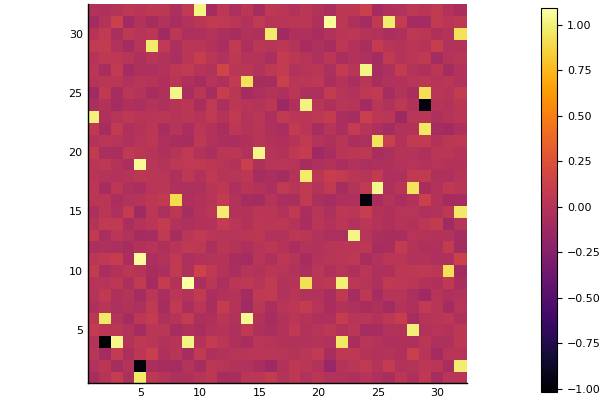

In [9]:
V⁺, V⁻ = vortexSnapshot(ψ_ref);
V⁺ = V⁺/two_pi; V⁻ = V⁻/two_pi
heatmap(1:L, 1:L, V⁺[:,:,7], aspect_ratio=1)

In [20]:
V⁺[1,4,1]

-0.05743337461439709

In [27]:
vorticitySum(V⁺[:,:,7], visible=true)

(+1) voriticty:	36
(-1) vorticity:	4
net vorticity:	32.00000000000001


(36, 4, 32.00000000000001)

In [28]:
# Let's measure the average number of vorticies in the planes
sum_1 = Array{Int64, 1}(L₃); sum_m1 = Array{Int64, 1}(L₃); sum_net = Array{Float64, 1}(L₃);
for z = 1:L₃
    sum_1[z], sum_m1[z], sum_net[z] = vorticitySum(V⁺[:,:,z])
end
println("(+1) vorticity:\t$(mean(sum_1)) ± $(std(sum_1)/sqrt(L₃))\n(-1) vorticity:\t$(mean(sum_m1)) ± $(std(sum_m1)/√(L₃))\nnet vorticity:\t$(mean(sum_net)) ± $(std(sum_net)/√(L₃))")

(+1) vorticity:	37.916666666666664 ± 0.7925632881080006
(-1) vorticity:	7.0 ± 0.7487363091276265
net vorticity:	32.00000000000001 ± 4.9764898722650506e-15


In [14]:
include("../../Source/functions_observables.jl")

averageAmplitudes! (generic function with 1 method)

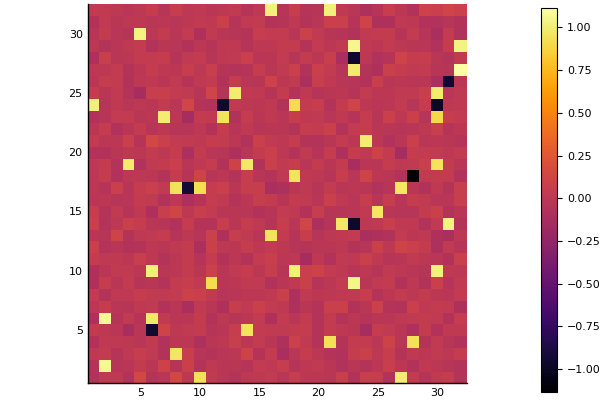

In [17]:
V⁺, V⁻ = vortexSnapshot(ψ_ref);
V⁺ = V⁺/two_pi; V⁻ = V⁻/two_pi
heatmap(1:L, 1:L, V⁺[:,:,1], aspect_ratio=1)

In [29]:
# Including ψ_ref in the list of states as the last state
ψ_list = vcat(ψ_w, [ψ_ref])
Δt = min(Δt, ceil(Int64, t₀*THERM_FRAC))
println(Δt)
println("\nMeasuring structure function and vortex lattice
--------------------------------------------------------------------------------------")
@time (av_V⁺, err_V⁺, V⁺, av_V⁻, err_V⁻, V⁻, av_S⁺, err_S⁺, S⁺, av_S⁻, err_S⁻, S⁻) = parallelSFVLA!(k_matrix, ψ_list, sim_ref, M, Δt);

1000

Measuring structure function and vortex lattice
--------------------------------------------------------------------------------------
Starting 300 measurements on 3 processes doing max 100 measurements each
on a 32×32 system, corresponding to 100000 MCS pr. process
Measurement progress: 10%
Measurement progress: 20%
Measurement progress: 30%
Measurement progress: 40%
Measurement progress: 50%
Measurement progress: 60%
Measurement progress: 70%
Measurement progress: 80%
Measurement progress: 90%
Measurement progress: 100%
Measurements done, collecting parallell results.
Parallell measurements done. Processing.

Sum of vorticity of random snapshot:
V⁺: 	32.00000000000001
V⁻: 	32.00000000000001

Max (S⁺, S⁻)
(1.0, 1.0000000000000002)
Max δ(S⁺, S⁻)
(3.471381525975345e-5, 0.00014688464579280867)
Max correlation time
(22.69223344821115, 21.80887322408913)
4022.705251 seconds (23.86 G allocations: 699.912 GiB, 13.42% gc time)


In [30]:
plotStructureFunctionVortexLatticeS(ψ_ref, av_V⁺, av_V⁻, av_S⁺, av_S⁻, k_matrix)

S⁺(0) ≈ 1.0
S⁻(0) ≈ 1.0000000000000002
The proportion of vortices (n⁺, n⁻) in snapshot
% of vortex kind (-1, -1): 	0
% of vortex kind (-1, 0): 	0
% of vortex kind (-1, 1): 	0
% of vortex kind (0, -1): 	15
% of vortex kind (0, 0): 	62
% of vortex kind (0, 1): 	19
% of vortex kind (1, -1): 	1
% of vortex kind (1, 0): 	2
% of vortex kind (1, 1): 	0

Sum of + component vorticity in the snapshot: 32.0
Sum of - component vorticity in the snapshot: 31.999999999999982


1

In [31]:
pyplot()

Plots.PyPlotBackend()

In [32]:
meanAmplitudes(ψ_ref)

(1.0, 0.0)

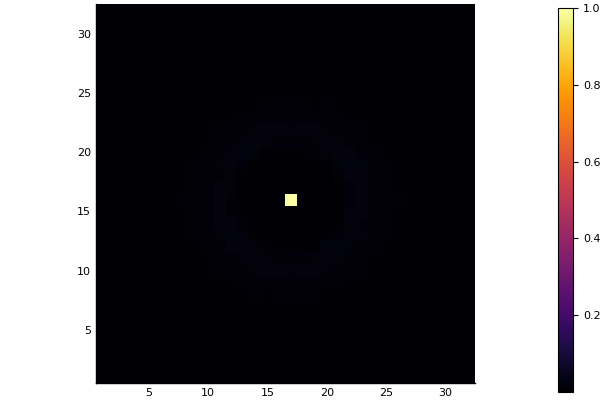

In [33]:
heatmap(1:L, 1:L, av_S⁺, aspect_ratio=1)

In [34]:
av_S⁺[floor(Int64, L/2), floor(Int64, L/2+1)] = av_S⁺[floor(Int64, L/2+1), floor(Int64, L/2+1)]

0.0001578686471250363

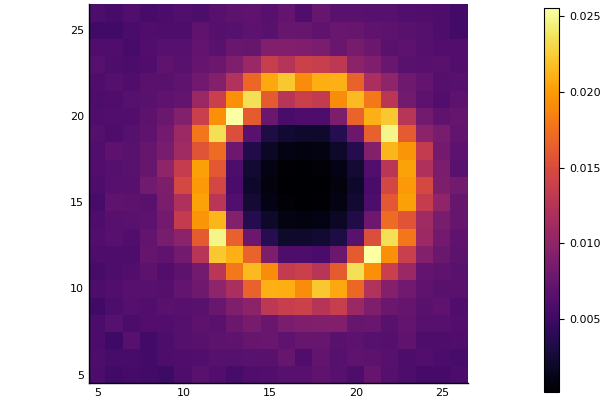

In [36]:
iₛ = floor(Int64, L/2-L/3)
iₑ = floor(Int64, L/2+L/3)
int = iₛ:iₑ
heatmap(int, int, av_S⁺[int,int], aspect_ratio=1)

# Plotting vortices

In [57]:
V⁺, V⁻ = vortexSnapshot(ψ_ref);

In [61]:
V⁺[:,:,1]/two_pi

12×12 Array{Float64,2}:
 -0.980428     -0.00804258    0.0203584   …  -0.00707123   0.991935  
  0.991756      0.0117772    -0.0125901       0.995245     0.00639081
  0.995777     -0.00400519    0.00253546     -0.00475799  -0.988861  
  0.00148081   -0.00729163    0.0167555      -0.00636403   0.00117494
  1.00839      -0.0092801     0.00332366     -0.00659443  -0.998628  
 -0.002784      0.000354574  -0.00803036  …  -0.0106892    0.0141879 
 -0.00166397   -0.0108946     0.00249434      0.00276403   1.00625   
  0.983894     -0.997717      1.00083        -0.0188482    0.0204099 
 -0.0107725     0.00254493   -1.00922         1.00686      0.00175362
  0.999555      1.0082       -0.00130028      0.00909138  -1.00891   
  0.00318667   -0.00156058    0.00467813  …   0.978204     0.00377117
 -0.000647805  -0.00590822    0.99738         0.00788277  -0.986875  

In [93]:
function getCoords(quanta::Float64, V::Array{Float64, 3})
    L = size(V,1)
    L₃ = size(V,3)
    i = 0
    coords = Array{Array{Float64, 1}, 1}(L^2*L₃)
    
    for z_pos=1:L₃, v_pos=1:L, h_pos=1:L
        if isapprox(V[v_pos, h_pos, z_pos]/two_pi, quanta, atol=0.1, rtol=0.0)
            i += 1
            coords[i] = [Float64(v_pos), Float64(h_pos), Float64(z_pos)]
        end
    end
    return coords[1:i]
end

getCoords (generic function with 1 method)

In [70]:
coords = Array{Array{Int64, 1}, 1}(length(V⁺));
L = size(V⁺,1)
L₃ = size(V⁺,3)
i = 0
for z_pos=1:L₃, v_pos = 1:L, h_pos = 1:L
    if isapprox(V⁺[v_pos, h_pos, z_pos]/two_pi, 1.0; atol=0.1, rtol=0.0)
#        println(V⁺[v_pos, h_pos, z_pos]/two_pi)
        i += 1
        coords[i] = [h_pos, v_pos, z_pos]
    end
end

0.9854230439734353
0.9834323215917189
0.9919354449517346
0.9917561683448144
1.0116392612358107
1.0025827004336063
0.9952447833981032
0.9957771336105953
1.0063707995423916
1.0108320068890593
1.0083932518718275
1.0146222933936966
0.9953056684655845
0.9988334226655602
1.006254626173718
0.9838941276897598
1.0008287039800747
1.0068623922129296
0.9995554149294051
1.008199876051766
0.989080922516196
0.9782037695009611
0.9973795794239186
1.001355320610422
0.9948093957405169
0.99350553927247
0.9982642866465535
1.0053911744957755
1.000001644844963
0.9858875638410609
1.0022598194812853
1.0046814848669
0.9802571005140782
1.0020367304931794
0.9904103314107064
1.0004159985567416
0.982516991001606
1.0005150078497909
1.007598537559323
0.9954202727110311
1.006746890272737
0.9999212961647649
1.005920785709148
1.007170973213466
0.9860338470296878
0.9862309387019749
1.0051100196399003
1.0089218610709663
0.9827562879987148
0.9871520862796326
1.0139661975155307
1.0046683143902173
0.9941444263432808
1.010594

In [73]:
quant1 = coords[1:i]

301-element Array{Array{Int64,1},1}:
 [7, 1, 1]   
 [10, 1, 1]  
 [12, 1, 1]  
 [1, 2, 1]   
 [4, 2, 1]   
 [9, 2, 1]   
 [11, 2, 1]  
 [1, 3, 1]   
 [5, 3, 1]   
 [8, 3, 1]   
 [1, 5, 1]   
 [10, 5, 1]  
 [7, 6, 1]   
 ⋮           
 [4, 7, 12]  
 [10, 7, 12] 
 [6, 8, 12]  
 [11, 8, 12] 
 [12, 8, 12] 
 [2, 9, 12]  
 [9, 9, 12]  
 [6, 10, 12] 
 [10, 10, 12]
 [11, 10, 12]
 [12, 10, 12]
 [7, 11, 12] 

In [86]:
Float64(quant1[1][3])

1.0

In [118]:
# define the Lorenz attractor
mutable struct Lorenz
    dt; σ; ρ; β; x; y; z
end

function step!(l::Lorenz)
    dx = l.σ*(l.y - l.x)       ; l.x += l.dt * dx
    dy = l.x*(l.ρ - l.z) - l.y ; l.y += l.dt * dy
    dz = l.x*l.y - l.β*l.z     ; l.z += l.dt * dz
end

attractor = Lorenz([dt = 0.02, σ = 10., ρ = 28., β = 8//3, x = 1., y = 1., z = 1.]...)


# initialize a 3D plot with 1 empty series
plt = plot3d(2, xlim=(0,14), ylim=(0,14), zlim=(0,14), line=[:scatter3d, :scatter3d], title = "Vortex Matrix", markersize = [3, 30], markershape = [:circle, :circle])

for i = 1:length(quant1)
    step!(attractor)
    push!(plt, Float64(quant1[i][1]), Float64(quant1[i][2]), Float64(quant1[i][3]))
end
display(plt)

LoadError: [91mMethodError: no method matching is3d(::Array{Symbol,2})[0m
Closest candidates are:
  is3d([91m::Dict{Symbol,Any}[39m) at /home/nicolai/.julia/v0.6/Plots/src/args.jl:93
  is3d([91m::Plots.Series[39m) at /home/nicolai/.julia/v0.6/Plots/src/args.jl:92
  is3d([91m::Symbol[39m) at /home/nicolai/.julia/v0.6/Plots/src/args.jl:91
  ...[39m

In [94]:
quantMin1 = getCoords(-1.0, V⁺)
length(quantMin1)

157

In [114]:
for i = 1:length(quantMin1)
    push!(plt, quantMin1[i][2], quantMin1[i][1], quantMin1[i][3], markershape=:star1)
end

LoadError: [91mfunction push! does not accept keyword arguments[39m

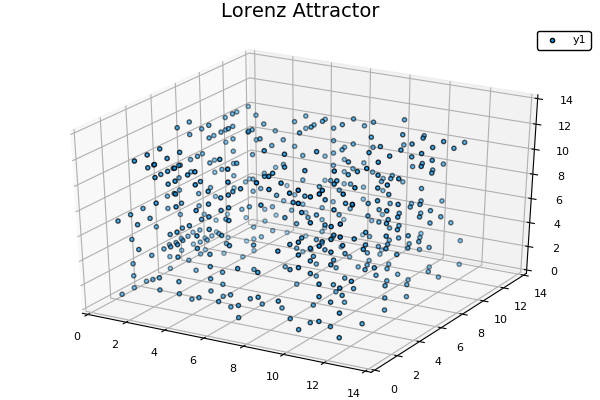

In [113]:
display(plt)